

# Deep Fake Detection Model

The requirement is to use Convolutional Neural Network model to classify all given images into fake and original.

First, we need to import all the libraries that we are going to need to complete the task. As a nn library, we will be using pyTorch. Also, for the data preprocessing we are using numpy, and for the visualization we will be using pyplot.

In [1]:
import glob
import os

import matplotlib_inline
import IPython.core.display         

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import string
import skimage.io
import skimage.color
import skimage.util

import PIL

import random

## Data Preprocessing

Number of original images: 4000

Number of manipulated images: 8000
- F2F: 1335    
- eyes: 1333    
- mouth: 1333
- NT: 1333
- DF: 1333
- FS: 1333


Since, the manipulations can be different on deepfake images, the training, validating, and testing data should have proportional amount of each manipulation image.

### Load the images

In [2]:
transform = T.Resize(size = (260,260))

manipulated_paths = glob.glob('./data/manipulated/*.png')
original_paths = glob.glob('./data/original/*.png')


f2f = []
eyes = []
mouth = []
nt = []
df = []
fs = []

original_images = []
manipulated_images = []

#### Load manipulated images according to their type

In [3]:
if len(manipulated_paths) == 0:
    print("Could not find imgdb directory!  " +  "Make sure you put it here: " + os.getcwd() )
else:
    
    # load image data
    for path in manipulated_paths:
        
#         img = skimage.io.imread(path, pilmode='L')
        img = PIL.Image.open(path).convert('L')
        img = transform(img)
        
        name = os.path.split(path)[-1]
        manipulation_type = name.split('_')[0]
        
        if (manipulation_type == 'F2F'):
            f2f.append(img)
        elif (manipulation_type == 'eyes'):
            eyes.append(img)
        elif (manipulation_type == 'mouth'):
            mouth.append(img)
        elif (manipulation_type == 'NT'):
            nt.append(img)
        elif (manipulation_type == 'DF'):
            df.append(img)
        elif (manipulation_type == 'FS'):
            fs.append(img)
            
manipulated_images = [f2f, eyes, mouth, nt, df, fs]

(260, 260)


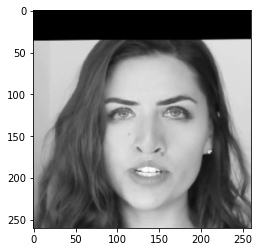

In [4]:
print(f2f[0].size)
plt.imshow(f2f[0], cmap="gray")

#### Load original images

In [5]:
if len(original_paths) == 0:
    print("Could not find imgdb directory!  " +  "Make sure you put it here: " + os.getcwd() )
else:
    
    # load image data
    for path in original_paths:
        # load image - byte [0 to 255]
#         img = skimage.io.imread(path, pilmode='L')
        img = PIL.Image.open(path).convert('L')
        img = transform(img)
        original_images.append(img)

(260, 260)


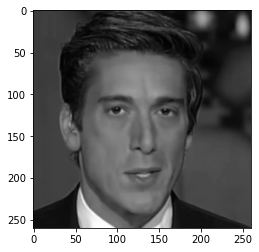

In [6]:
print(original_images[0].size)
plt.imshow(original_images[0], cmap="gray")

### Creating training, validating, and training sets

In [7]:
trainX = []
trainY = []

valX = []
valY = []

testX = []
testY = []

In [8]:
# Manipulated
for x in manipulated_images:
    for i in range(1000):
        index = random.randint(0, len(x) - 1)
        item = x.pop(index)
        trainX.append(item)
        trainY.append(0)


In [9]:
# Original
for i in range(3000):
    index = random.randint(0, len(original_images) - 1)
    item = original_images.pop(index)
    trainX.append(item)
    trainY.append(1)

In [10]:
for x in manipulated_images:
    print(len(x))

print('\n', len(original_images))

335
333
333
333
333
333

 1000


In [11]:
for x in manipulated_images:
    for i in range(166):
        index = random.randint(0, len(x) - 1)
        item = x.pop(index)
        valX.append(item)
        valY.append(0)

# Original
for i in range(500):
    index = random.randint(0, len(original_images) - 1)
    item = original_images.pop(index)
    valX.append(item)
    valY.append(1)

In [12]:
for x in manipulated_images:
    print(len(x))

print('\n', len(original_images))

169
167
167
167
167
167

 500


In [13]:
# Manipulated
for x in manipulated_images:
    for i in range(len(x)):
        index = random.randint(0, len(x) - 1)
        item = x.pop(index)
        testX.append(item)
        testY.append(0)

# Original
for i in range(500):
    index = random.randint(0, len(original_images) - 1)
    item = original_images.pop(index)
    testX.append(item)
    testY.append(1)

In [14]:
for x in manipulated_images:
    print(len(x))

print('\n', len(original_images))

0
0
0
0
0
0

 0


In [15]:
print('Training set size: ', len(trainX))
print('Training set size: ', len(trainY))

print('Validation set size: ', len(valX))
print('Validation set size: ', len(valY))

print('Testing set size: ', len(testX))
print('Testing set size: ', len(testY))

Training set size:  9000
Training set size:  9000
Validation set size:  1496
Validation set size:  1496
Testing set size:  1504
Testing set size:  1504


## Defining the Model

So, now we have the training, validation, and testing data stored in trainX, valX, and testX lists. Also, their correspding classes are stored in trainY, valY, and testY lists. The images are stored as grayscale images.

In [22]:
print(trainX[8999]
plt.imshow(trainX[8999], cmap="gray")
print(trainY[8999])

AttributeError: shape

### Network

The images are 299×299  pixels in size, so we don’t need a very complicated network. We can just build a simple CNN like this:

In [17]:
from torch.nn import Conv2d, ReLU, Linear

class Network(nn.Module):
    def __init__(self):
        super().__init__()
    

        # define layers
        self.conv1 = Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5))
    
        self.conv2 = Conv2d(in_channels=6, out_channels=12, kernel_size=(5, 5))
    
        self.fc1 = Linear(in_features=12*24*24, out_features=7688)
        self.fc2 = Linear(in_features=7688, out_features=320)
    
        self.output = Linear(in_features=320, out_features=1)
    
    
    # define forward function
    def forward(self, t):
        # convolution 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)


        # convolution 2
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.output(t)
        
        # don't need softmax here since we'll use cross-entropy as activation.

        return t